In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import numpy as np
from numpy.linalg import solve
from scipy.optimize import root,minimize
import matplotlib.pyplot as plt
from tqdm import trange

import rpl as rpl
import sim_fun as sfun
import sim_util as sutil

# Define values necessary to fit parameters

In [43]:
kRS = 0.04
kFS = 0.02
nRS = 1.6
nFS = 2.4

cI = 30
cC = 50
cB = 80

rEI = 1.5
rEC = 2.5
rEB = 3.5
rPI = 16.0
rPC = 20.0
rPB = 23.5

rEerr = 0.5
rPerr = 3.0

hEI = (rEI/kRS)**(1/nRS)
hEC = (rEC/kRS)**(1/nRS)
hEB = (rEB/kRS)**(1/nRS)
hPI = (rPI/kFS)**(1/nFS)
hPC = (rPC/kFS)**(1/nFS)
hPB = (rPB/kFS)**(1/nFS)

def rate_loss_func(rs):
    res = np.zeros(6)
    
    res[0] = (rs[0,0]-rEI)/rEerr
    res[1] = (rs[1,0]-rEC)/rEerr
    res[2] = (rs[2,0]-rEB)/rEerr
    res[3] = (rs[0,1]-rPI)/rPerr
    res[4] = (rs[1,1]-rPC)/rPerr
    res[5] = (rs[2,1]-rPB)/rPerr
    
    return 0.5*np.sum(res**2)

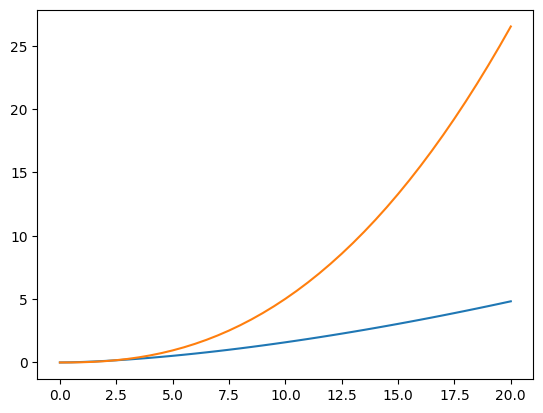

In [44]:
hs = np.linspace(0,20,41)
plt.plot(hs,kRS*hs**nRS)
plt.plot(hs,kFS*hs**nFS)

In [45]:
print([hEI,hEC,hEB])
print([hPI,hPC,hPB])

[9.63317704975859, 13.256382014787597, 16.358935238776557]
[16.203947518373056, 17.782794100389232, 19.01877078898472]


In [46]:
rp = rpl.RPL([kRS, kFS, kRS ],
             [nRS, nFS, nRS ],
             [50,  100, 50  ],
             [0.03,0.01,0.03])

# Define functions necessary to fit parameters

In [47]:
def safe_softplus(x, k=1, limit=30):
    if x>limit:
        return x
    else:
        return np.log1p(np.exp(k*x))/k

In [61]:
def input_func(x):
    gE  = 10**x[0]
    gP  = 10**x[1]
    gS  = 10**x[2]
    bS  = 10**x[3]
    WEE = 10**x[4]
    WEP = 10**x[5]
    WES = 10**x[6]
    WPE = 10**x[7]
    WPP = 10**x[8]
    WPS = 10**x[9]
    WSE = 10**x[10]
    WSP = 10**x[11]
    
#     u = np.zeros(6)
    
#     u[0] = WEE*rEI - WEP*rPI - WES*kRS*safe_softplus(WSE*rEI - WSP*rPI + bS + gS*cI,5)**nRS + gE*cI
#     u[1] = WPE*rEI - WPP*rPI - WPS*kRS*safe_softplus(WSE*rEI - WSP*rPI + bS + gS*cI,5)**nRS + gP*cI
#     u[2] = WEE*rEC - WEP*rPC - WES*kRS*safe_softplus(WSE*rEC - WSP*rPC + bS + gS*cC,5)**nRS + gE*cC
#     u[3] = WPE*rEC - WPP*rPC - WPS*kRS*safe_softplus(WSE*rEC - WSP*rPC + bS + gS*cC,5)**nRS + gP*cC
#     u[4] = WEE*rEB - WEP*rPB - WES*kRS*safe_softplus(WSE*rEB - WSP*rPB + bS + gS*cB,5)**nRS + gE*cB
#     u[5] = WPE*rEB - WPP*rPB - WPS*kRS*safe_softplus(WSE*rEB - WSP*rPB + bS + gS*cB,5)**nRS + gP*cB
    
    u = np.zeros(4)
    
    u[0] = WEE*rEI - WEP*rPI - WES*kRS*safe_softplus(WSE*rEI - WSP*rPI + bS + gS*cI,10)**nRS + gE*cI
    u[1] = WPE*rEI - WPP*rPI - WPS*kRS*safe_softplus(WSE*rEI - WSP*rPI + bS + gS*cI,10)**nRS + gP*cI
    u[2] = WEE*rEC - WEP*rPC - WES*kRS*safe_softplus(WSE*rEC - WSP*rPC + bS + gS*cC,10)**nRS + gE*cC
    u[3] = WPE*rEC - WPP*rPC - WPS*kRS*safe_softplus(WSE*rEC - WSP*rPC + bS + gS*cC,10)**nRS + gP*cC
#     u[4] = WEE*rEB - WEP*rPB - WES*kRS*safe_softplus(WSE*rEB - WSP*rPB + bS + gS*cB,5)**nRS + gE*cB
#     u[5] = WPE*rEB - WPP*rPB - WPS*kRS*safe_softplus(WSE*rEB - WSP*rPB + bS + gS*cB,5)**nRS + gP*cB
    
    return u

def err_func(x):
    u = input_func(x)
    
#     f = np.zeros(6)
    
#     f[0] = 1 - u[0]/hEI
#     f[1] = 1 - u[1]/hPI
#     f[2] = 1 - u[2]/hEC
#     f[3] = 1 - u[3]/hPC
#     f[4] = 1 - u[4]/hEB
#     f[5] = 1 - u[5]/hPB
    
    f = np.zeros(4)
    
    f[0] = 1 - u[0]/hEI
    f[1] = 1 - u[1]/hPI
    f[2] = 1 - u[2]/hEC
    f[3] = 1 - u[3]/hPC
#     f[4] = 1 - u[4]/hEB
#     f[5] = 1 - u[5]/hPB
    
    f[u < 0] *= 1e2
    
    return f

def loss_func(x):
    f = err_func(x)
    
    return np.sum(f**2)

# Test fitting on a single initial point

In [66]:
sol = minimize(loss_func,np.concatenate((np.ones(1),0.2*np.ones(1),np.ones(1),0*np.ones(1),0*np.ones(8))))#,
               #bounds=np.vstack((np.zeros(12),10*np.ones(12))).T,tol=1e-12)
print(err_func(sol.x))
print(sol)

[-11.36546244  -1.21904276 -14.26583008  -2.60338301]
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 340.9513126296814
        x: [ 6.560e-01  2.357e-01  1.374e-02 -1.956e-03 -9.447e-04
             8.786e-03 -2.500e-01  1.130e-03 -9.772e-03 -3.474e-01
            -4.443e-03  3.683e-02]
      nit: 2
      jac: [ 1.860e+03  7.589e+01 -1.172e+02 -2.694e+00  2.049e+01
            -1.899e+02 -4.078e+01  2.211e+00 -1.860e+01 -3.835e+00
            -5.622e+00  5.419e+01]
 hess_inv: [[ 7.643e-04  1.096e-03 ...  7.894e-04 -7.862e-03]
            [ 1.096e-03  9.988e-01 ...  1.523e-04 -1.278e-03]
            ...
            [ 7.894e-04  1.523e-04 ...  1.000e+00  1.733e-04]
            [-7.862e-03 -1.278e-03 ...  1.733e-04  9.985e-01]]
     nfev: 856
     njev: 65


1468.4817139141453


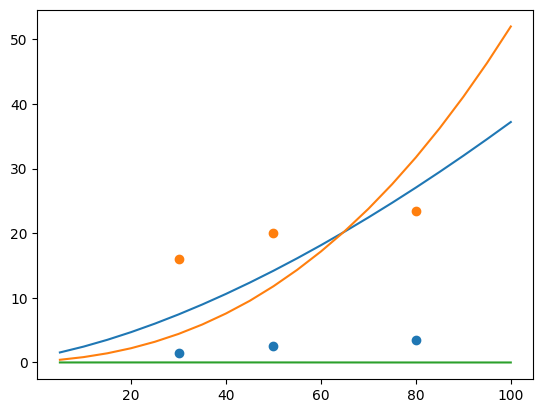

In [67]:
reload(sutil)

vs,rs,_ = sutil.sim_rates(rp,np.arange(0,10,rp.taus[1]/3),sutil.get_prms_dict(sol.x),np.array([30,50,80]))
plt.scatter(np.array([30,50,80]),np.array([rEI,rEC,rEB]),c='C0')
plt.scatter(np.array([30,50,80]),np.array([rPI,rPC,rPB]),c='C1')
print(rate_loss_func(rs))

vs,rs,_ = sutil.sim_rates(rp,np.arange(0,5,rp.taus[1]/3),sutil.get_prms_dict(sol.x))
plt.plot(sutil.cs,rs[:,0],c='C0')
plt.plot(sutil.cs,rs[:,1],c='C1')
plt.plot(sutil.cs,rs[:,2],c='C2')

/Users/tuannguyen/MD_SOM_Gamma/notebooks/./../scripts/sim_fun.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  As[i] = np.vdot(Gdage,ceta@Gdage)*2*corr_tau/((2*np.pi*fs[i]*corr_tau)**2+1)


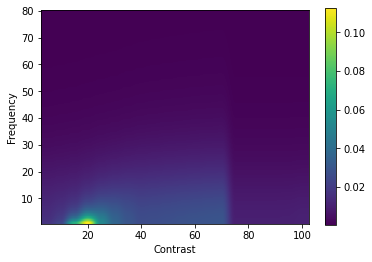

In [10]:
reload(sutil)
As = sutil.sim_lfp(rp,vs,sutil.get_prms_dict(sol.x))

plt.imshow(As,origin='lower',extent=((sutil.cs[0]-(sutil.cs[1]-sutil.cs[0])/2,
                                      sutil.cs[-1]+(sutil.cs[1]-sutil.cs[0])/2,
                                      sutil.fs[0]-(sutil.fs[1]-sutil.fs[0])/2,
                                      sutil.fs[-1]+(sutil.fs[1]-sutil.fs[0])/2)))
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.colorbar()

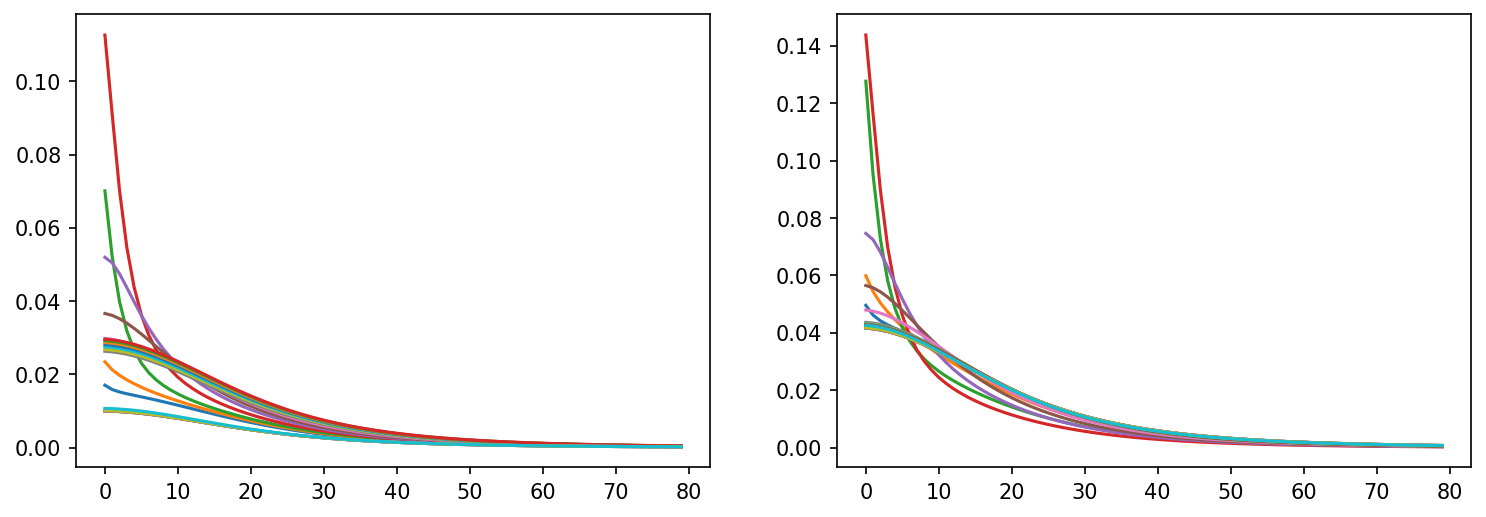

In [11]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=150)
axs[0].plot(As)#/((sutil.fs[1]-sutil.fs[0])*np.sum(As,axis=0)))
axs[1].plot(As/((sutil.fs[1]-sutil.fs[0])*np.sum(As,axis=0)))

# Fit to many initial parameters

In [68]:
ntries = 50000

In [69]:
# np.save('fit_prms',fit_prms)
# np.save('fit_vs',fit_vs)
# np.save('fit_rs',fit_rs)
# np.save('fit_fs',fit_fs)
# np.save('fit_Ps',fit_Ps)
# np.save('fit_losses',fit_losses)

fit_prms = np.load('fit_prms.npy')
fit_vs = np.load('fit_vs.npy')
fit_rs = np.load('fit_rs.npy')
fit_fs = np.load('fit_fs.npy')
fit_Ps = np.load('fit_Ps.npy')
fit_losses = np.load('fit_losses.npy')

In [71]:
fit_prms = np.zeros((ntries,12))

for i in trange(ntries):
    x0 = [sutil.gen_rand_prm(i)[key] for key in list(sutil.prm_idxs.keys())]
    sol = minimize(loss_func,x0,bounds=np.vstack((np.zeros(12),30*np.ones(12))).T,tol=1e-12)
    fit_prms[i] = sol.x

  0%|                                                                                           | 1/50000 [00:00<1:49:44,  7.59it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
  0%|                                                                                           | 4/50000 [00:00<1:07:40, 12.31it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  W

  0%|                                                                                            | 56/50000 [00:03<50:20, 16.54it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
  0%|                                                                                            | 59/50000 [00:03<46:09, 18.03it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WE

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:5: RuntimeWarning: overflow encountered in scalar power
  bS  = 10**x[3]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:11: RuntimeWarning: overflow encountered in scalar power
  WPS = 10**x[9]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:12: RuntimeWarning: overflow encountered in scalar power
  WSE = 10**x[10]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:26: RuntimeWarning: invalid value encountered in scalar multiply
  u[0] = WEE*rEI - WEP*rPI - WES*kRS*safe_softplus(WSE*rEI - WSP*rPI + bS + gS*cI,10)**nRS + gE*cI

  0%|▏                                                                                        | 108/50000 [00:07<1:06:33, 12.49it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
  0%|▏                                                                                          | 113/50000 [00:07<58:03, 14.32it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  

  0%|▎                                                                                          | 152/50000 [00:09<51:47, 16.04it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
  0%|▎                                                                                          | 155/50000 [00:09<49:24, 16.82it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  retur

  0%|▍                                                                                          | 211/50000 [00:13<58:02, 14.30it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountere

  1%|▍                                                                                          | 259/50000 [00:16<50:32, 16.40it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in s

  1%|▌                                                                                          | 302/50000 [00:19<47:36, 17.40it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountere

  1%|▌                                                                                          | 313/50000 [00:19<50:28, 16.40it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
  1%|▌                                                                                          | 316/50000 [00:20<47:06, 17.58it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  

  1%|▌                                                                                          | 323/50000 [00:20<52:27, 15.79it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in s

  1%|▋                                                                                        | 379/50000 [00:24<1:01:23, 13.47it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
  1%|▋                                                                                          | 382/50000 [00:24<57:22, 14.41it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:7: RuntimeWarning: overflow encountered in scalar power
  WEP = 10**x[5]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return 

  1%|▋                                                                                        | 419/50000 [00:27<1:06:56, 12.34it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in squ

  1%|▊                                                                                        | 467/50000 [00:30<1:04:02, 12.89it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/usr/local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:10: RuntimeWarning: overflow encountered in scalar power
  WPP = 10**x[8]
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  return np.sum(f**2)
  1%|▊                                                                                          | 470/50000 [00:30<59:44, 13.82it/s]/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_84939/929878040.py:63: RuntimeWarning: overflow encountered in square
  retur

KeyboardInterrupt: 

In [19]:
fit_vs = np.zeros((ntries,3,3))
fit_rs = np.zeros((ntries,3,3))
fit_losses = np.zeros(ntries)

for i in trange(ntries):
    this_vs,this_rs,_ = sutil.sim_rates(rp,np.arange(0,5,rp.taus[1]/3),
                                  sutil.get_prms_dict(fit_prms[i]),np.array([30,50,80]))
    fit_vs[i] = this_vs
    fit_rs[i] = this_rs
    
    fit_losses[i] = rate_loss_func(this_rs)

100%|███████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [7:15:51<00:00,  1.91it/s]


In [157]:
fit_fs = np.zeros(ntries)
fit_Ps = np.zeros(ntries)

for i in trange(ntries):
    this_As = sutil.sim_lfp(rp,fit_vs[i,1:2,:],sutil.get_prms_dict(fit_prms[i]))[:,0]
    
    fit_fs[i] = sutil.fs[np.argmax(this_As)]
    fit_Ps[i] = np.max(this_As)/np.mean(this_As)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [16:08<00:00, 51.65it/s]


In [56]:
fit_Js = np.zeros((ntries,3,3))

for i in trange(ntries):
    fit_Js[i] = sutil.sim_jac(rp,fit_vs[i,1:2,:],sutil.get_prms_dict(fit_prms[i]))[0,:,:]

100%|███████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 8806.95it/s]


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9967e+04, 3.1000e+01]),
 array([-42.73995423, -37.75232666, -32.76469908, -27.7770715 ,
        -22.78944393, -17.80181635, -12.81418877,  -7.82656119,
         -2.83893362,   2.14869396,   7.13632154]),
 <BarContainer object of 10 artists>)

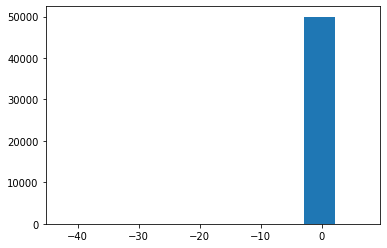

In [61]:
plt.hist(fit_Js[fit_Js[:,1,1]<10,1,1])

(array([ 8., 13., 11., 17.,  8., 10., 17., 13.,  9., 16.]),
 array([ 4.3047769 ,  7.85661545, 11.40845401, 14.96029256, 18.51213111,
        22.06396967, 25.61580822, 29.16764677, 32.71948533, 36.27132388,
        39.82316243]),
 <BarContainer object of 10 artists>)

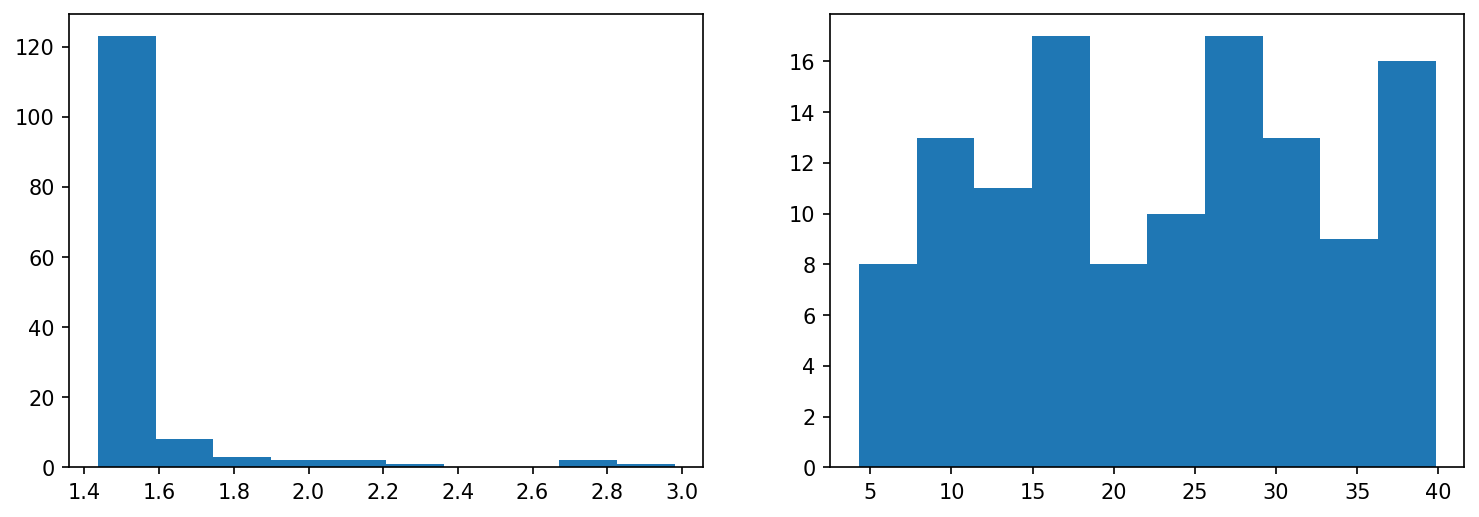

In [21]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=150)
cut = 3
axs[0].hist(fit_losses[fit_losses<cut])
axs[1].hist(fit_rs[np.logical_and(fit_losses<cut,fit_rs[:,2,2]<40),2,2])

In [31]:
good_fits = np.logical_and(np.logical_and(fit_losses<2,fit_rs[:,2,2]<15),
                           np.logical_and(fit_fs>20,fit_fs<40))

In [62]:
import pandas as pd
import seaborn as sns

prms_df = pd.DataFrame(np.hstack((fit_prms[good_fits,:],fit_rs[good_fits,2,2][:,np.newaxis],
                                  fit_fs[good_fits][:,np.newaxis],fit_Ps[good_fits][:,np.newaxis],
                                  fit_Js[good_fits,1,1][:,np.newaxis])),
                    columns=['gE','gP','gS','bS','WEE','WEP','WES','WPE','WPP','WPS','WSE','WSP',
                             'rS','f0','P0','JPP'])
prms_df

gE        gP        gS        bS       WEE       WEP       WES  \
0   0.417006  3.047278  0.073641  3.551939  2.248734  0.027703  2.235480   
1   0.270988  3.429822  0.024288  0.718022  2.949470  0.021901  2.398180   
2   0.263409  1.374062  0.005115  1.897754  4.528373  0.069443  1.909961   
3   0.656809  4.811609  0.073844  4.585084  2.210326  0.148855  4.290469   
4   0.525047  5.482850  0.082195  4.876227  1.863747  0.000716  3.006410   
5   0.351196  1.390427  0.000010  2.098192  4.337866  0.123740  2.921942   
6   0.480956  3.281856  0.060618  5.028207  3.003386  0.000966  3.264808   
7   0.267677  1.942225  0.025838  0.516956  2.309137  0.000005  2.759875   
8   0.383478  5.752910  0.060405  4.202266  2.864733  0.005218  2.142866   
9   0.466557  4.368949  0.050274  1.367256  2.727363  0.224399  3.395225   
10  0.535332  4.934519  0.062970  3.819534  3.041470  0.147353  3.439500   
11  0.332778  2.600405  0.041354  1.690890  2.274476  0.007011  3.868339   
12  0.344720  2.138340  0.033287  2.701599  3.397721  0.000575  4.244150   
13  0.247999  2.828149  0.021446  0.578274  3.034093  0.000018  1.861480   
14  0.327499  3.793697  0.047383  0.987483  2.074176  0.025847  2.811359   
15  0.288585  1.561635  0.005016  1.533692  4.875925  0.097852  4.998710   
16  0.430078  2.966197  0.054533  2.514321  2.319382  0.058294  4.047078   
17  0.379205  4.089195  0.075370  2.830624  1.863052  0.000002  2.109796   
18  0.448338  3.092342  0.055385  4.145127  2.641596  0.000000  3.821569   
19  0.274624  2.236792  0.020990  0.887469  3.065425  0.011734  4.108407   
20  0.452215  2.812074  0.047542  3.546618  2.788453  0.002702  5.115136   
21  0.327711  3.175028  0.042712  3.698224  3.530743  0.000560  1.999109   
22  0.322389  2.843191  0.030541  1.290488  3.152890  0.068799  3.074032   
23  0.293914  1.942362  0.028252  0.690058  2.424877  0.002369  5.064360   
24  0.304443  2.818206  0.051543  2.200690  2.373941  0.006449  1.551852   
25  0.291985  2.564871  0.021941  0.886409  3.439267  0.071535  2.298977   

             WPE       WPP        WPS       WSE       WSP         rS    f0  \
0   1.861740e-10  1.267025  15.150170  4.368714  0.000000  14.132288  27.0   
1   1.377055e+01  3.611324  27.460710  4.897198  0.012353   8.856015  30.0   
2   7.710922e+00  0.318623   8.725219  6.217280  0.001509  13.259929  30.0   
3   2.578359e-04  2.219475  29.959577  3.602452  0.024340  11.667264  25.0   
4   0.000000e+00  2.603483  29.722373  3.648989  0.000000  13.482107  28.0   
5   1.483394e+01  0.703392  12.757626  5.547924  0.000000  10.809562  23.0   
6   4.338527e+00  0.893116  20.838691  3.981717  0.017836  12.509117  37.0   
7   4.846330e-04  0.923210  17.821077  4.593580  0.063592   6.907423  30.0   
8   1.751194e+01  4.678180  29.999946  4.791897  0.023101  14.674065  34.0   
9   6.684264e+00  4.035901  29.852110  4.361271  0.009118   9.730839  22.0   
10  9.303835e+00  3.313927  30.000000  4.083473  0.001120  12.295773  27.0   
11  6.172963e-01  1.299810  27.567290  3.471995  0.025607   6.364148  29.0   
12  5.080178e+00  0.526070  23.923960  3.494812  0.000787   7.086773  34.0   
13  1.221472e+01  2.749896  18.986172  5.491195  0.000010  10.757286  31.0   
14  2.894930e+00  3.240685  29.918190  4.062361  0.013398   8.156214  26.0   
15  1.018769e+01  0.584357  23.996897  3.931195  0.000000   5.641957  25.0   
16  5.800733e-05  1.270086  25.913338  3.348340  0.000927   7.976730  21.0   
17  9.773708e-02  2.655208  21.111709  4.238986  0.001406  12.997437  26.0   
18  2.088312e+00  0.905992  24.542600  3.593208  0.030967   9.569417  35.0   
19  6.606450e+00  1.419135  29.981508  3.633524  0.000004   5.415501  29.0   
20  1.944041e+00  0.610693  29.580168  3.089168  0.012719   7.312389  34.0   
21  1.393815e+01  2.105138  17.729895  5.168633  0.001448  14.502900  35.0   
22  8.830573e+00  2.251145  24.728183  4.361290  0.003831   8.288031  28.0   
23  6.012951e-05  0.676442  29.995172  3.051015  0.001508   4.304777  25.0   
24  3.0

1.5283906547885264


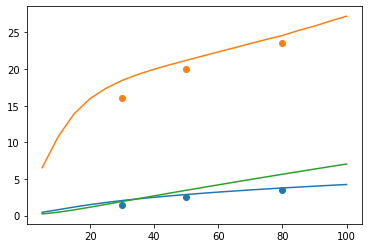

In [48]:
reload(sutil)

prms_dict = sutil.get_prms_dict(fit_prms[good_fits,:][15,:])

vs,rs,_ = sutil.sim_rates(rp,np.arange(0,10,rp.taus[1]/3),prms_dict,np.array([30,50,80]))
plt.scatter(np.array([30,50,80]),np.array([rEI,rEC,rEB]),c='C0')
plt.scatter(np.array([30,50,80]),np.array([rPI,rPC,rPB]),c='C1')
print(rate_loss_func(rs))

vs,rs,_ = sutil.sim_rates(rp,np.arange(0,5,rp.taus[1]/3),prms_dict)
plt.plot(sutil.cs,rs[:,0],c='C0')
plt.plot(sutil.cs,rs[:,1],c='C1')
plt.plot(sutil.cs,rs[:,2],c='C2')

2.3754865365555125


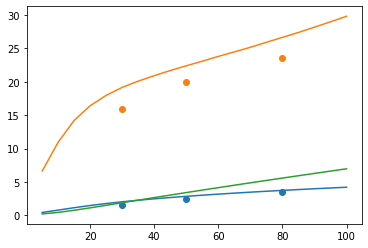

In [49]:
reload(sutil)

new_prms_dict = prms_dict.copy()
new_prms_dict['gP'] += 0.01

vs,rs,_ = sutil.sim_rates(rp,np.arange(0,10,rp.taus[1]/3),new_prms_dict,np.array([30,50,80]))
plt.scatter(np.array([30,50,80]),np.array([rEI,rEC,rEB]),c='C0')
plt.scatter(np.array([30,50,80]),np.array([rPI,rPC,rPB]),c='C1')
print(rate_loss_func(rs))

vs,rs,_ = sutil.sim_rates(rp,np.arange(0,5,rp.taus[1]/3),new_prms_dict)
plt.plot(sutil.cs,rs[:,0],c='C0')
plt.plot(sutil.cs,rs[:,1],c='C1')
plt.plot(sutil.cs,rs[:,2],c='C2')

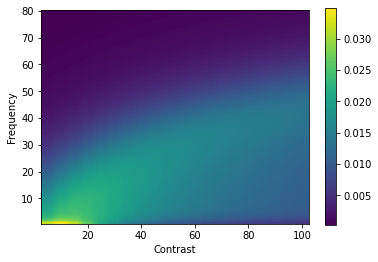

In [53]:
reload(sutil)
As = sutil.sim_lfp(rp,vs,prms_dict)

plt.imshow(As,origin='lower',extent=((sutil.cs[0]-(sutil.cs[1]-sutil.cs[0])/2,
                                      sutil.cs[-1]+(sutil.cs[1]-sutil.cs[0])/2,
                                      sutil.fs[0]-(sutil.fs[1]-sutil.fs[0])/2,
                                      sutil.fs[-1]+(sutil.fs[1]-sutil.fs[0])/2)))
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.colorbar()

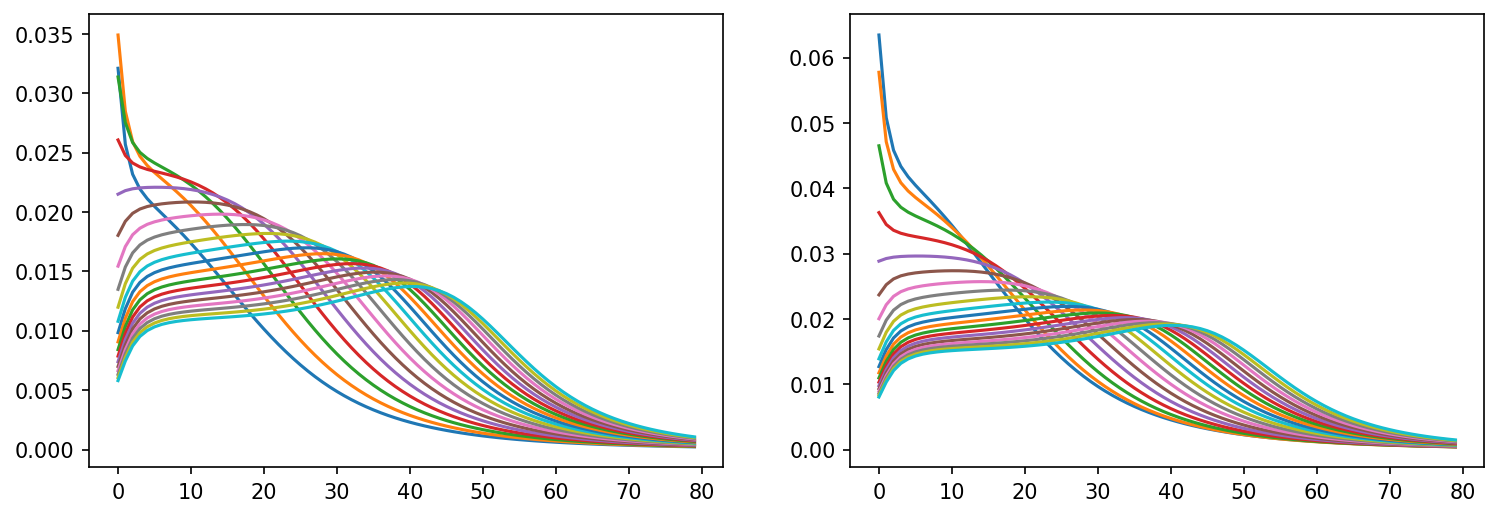

In [54]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=150)
axs[0].plot(As)#/((sutil.fs[1]-sutil.fs[0])*np.sum(As,axis=0)))
axs[1].plot(As/((sutil.fs[1]-sutil.fs[0])*np.sum(As,axis=0)))

In [47]:
jac = sutil.sim_jac(rp,vs,sutil.get_prms_dict(fit_prms[good_fits,:][15,:]))

print(jac[:,1,1])

[0.65477027 0.68656448 0.75390243 0.80117657 0.82802083 0.84252837
 0.85038997 0.85440793 0.85619781 0.85652659 0.85588675 0.85462545
 0.85294846 0.85094018 0.84877848 0.84660202 0.84375685 0.84119807
 0.83824317 0.83547192]


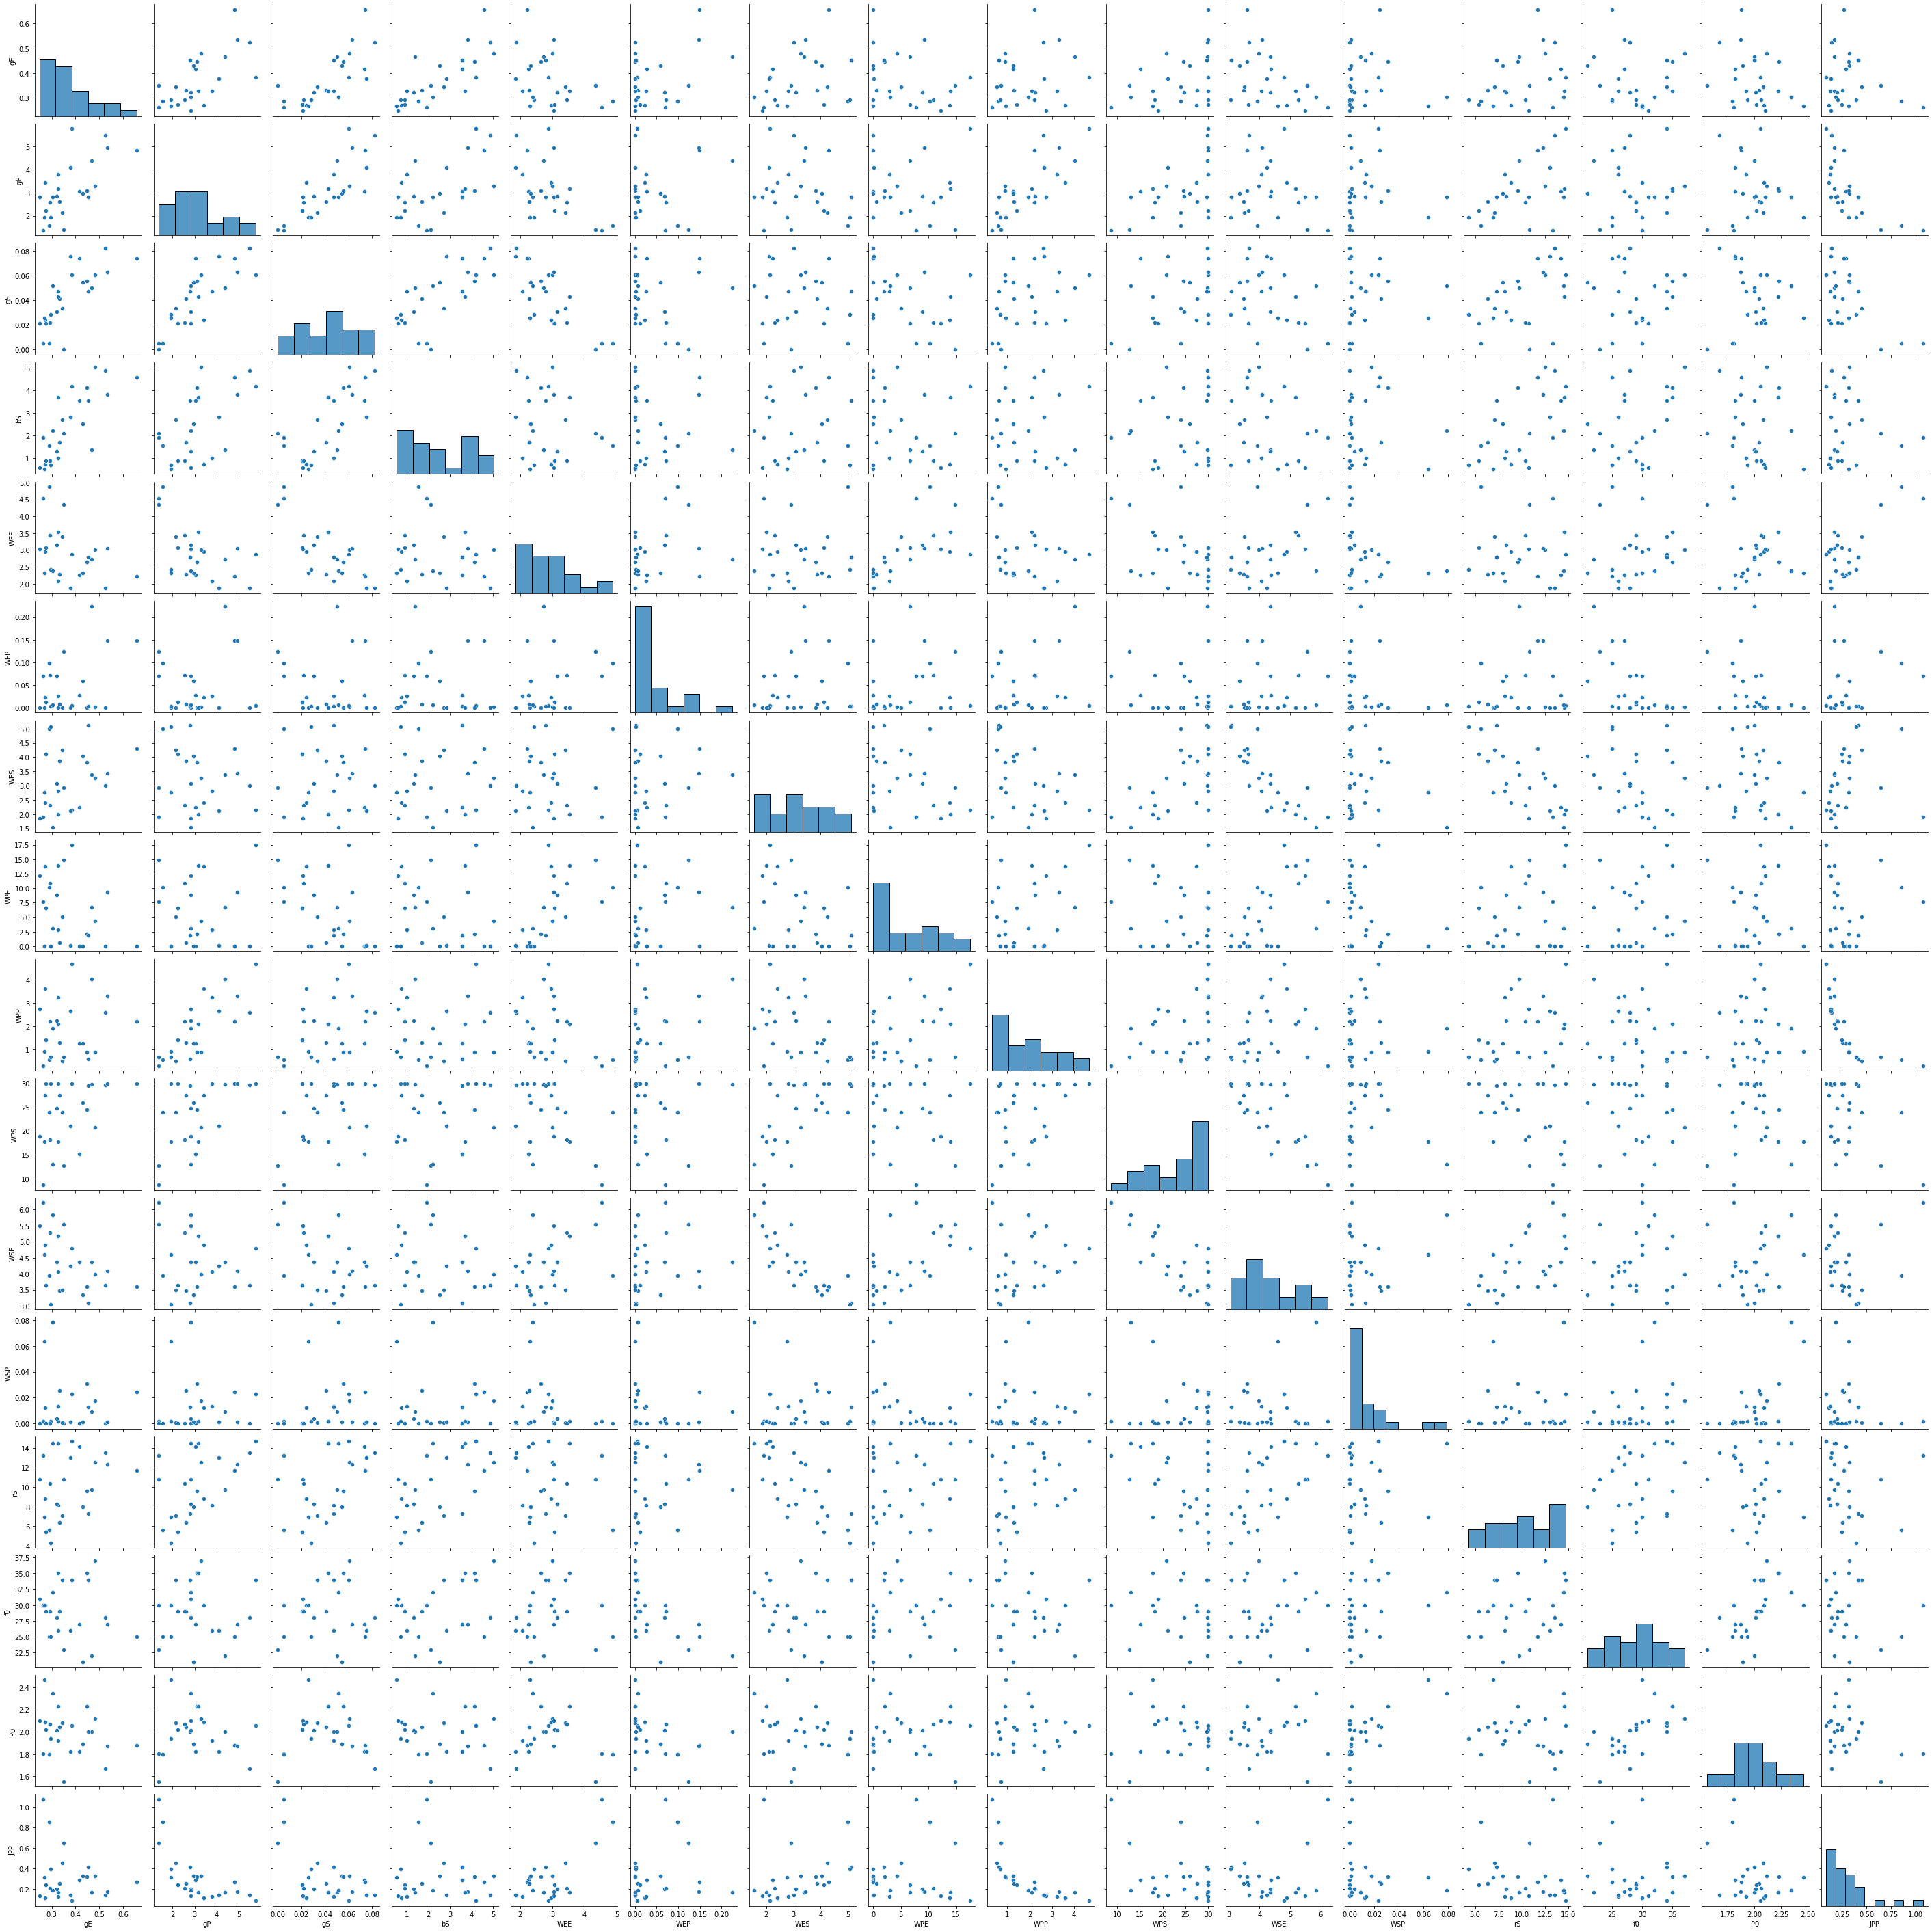

In [63]:
sns.pairplot(prms_df)

In [42]:
reload(sfun)
reload(sutil)

<module 'sim_util' from '/Users/tuannguyen/MD_SOM_Gamma/notebooks/./../scripts/sim_util.py'>

In [ ]:
sutil.sim_jac()